In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, accuracy_score, f1_score, roc_auc_score, roc_curve


import collections

c:\users\svetamira\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\svetamira\miniconda3\lib\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
c:\users\svetamira\miniconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  stacklevel=1)


### Загрузка и изучение датасета из kaggle
Информация из анкетных данных заемщиков и факт наличия дефолта

In [2]:
train = pd.read_csv('./sf-dst-scoring/train.csv')
test = pd.read_csv('./sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('./sf-dst-scoring/sample_submission.csv')

In [3]:
print('Размерность тренировочного датасета: ', train.shape)
display(train.head())
print('Размерность тестового датасета: ', test.shape)
display(test.head())
print('Размерность sample_submission: ', sample_submission.shape)
display(sample_submission.head())

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Размерность sample_submission:  (24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [4]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [5]:
test.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport'],
      dtype='object')

Описания полей

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

На первый взгляд все данные кажутся ок, кроме колонки app_date, ее можно преобразовать в более привычный для восприятия формат
Сделаем это

In [6]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)
print(train.app_date.head())
print(test.app_date.head())

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]
0   2014-03-22
1   2014-01-24
2   2014-03-23
3   2014-02-03
4   2014-02-04
Name: app_date, dtype: datetime64[ns]


Обработка пропусков

In [7]:
train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [8]:
test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [9]:
train['education'].isna().sum()/train['education'].value_counts().sum()

0.004177325423175312

In [10]:
test['education'].isna().sum()/test['education'].value_counts().sum()

0.004726629443308088

Как мы видим, пропуски встречаются только в информации об образовании клиентов и их мало, приблизительно 0,4%.

### Посмотрим на распределение образования

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='education', ylabel='count'>

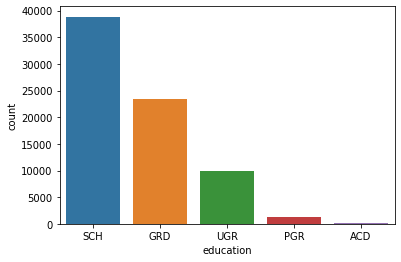

In [11]:
sns.countplot(train['education'])

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='education', ylabel='count'>

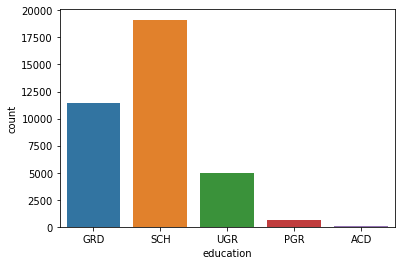

In [12]:
sns.countplot(test['education'])

Наблюдаются пять категорий. И в тренировочной, и в тестовой частях датасета большая часть заёмщиков имеет образование - SCH

Заполним пропуски в столбце образования наиболее частыми значениями

In [13]:
c1 = collections.Counter(train['education'])

train['education'].fillna(c1.most_common()[0][0], inplace=True)

c2 = collections.Counter(test['education'])

test['education'].fillna(c2.most_common()[0][0], inplace=True)

Проверим заполнение пропусков

In [14]:
train.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
dtype: int64

In [15]:
test.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
dtype: int64

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа

In [16]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

Посмотрим на распределение числовых данных в обучающей выборке

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


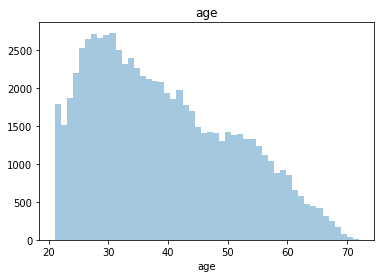

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


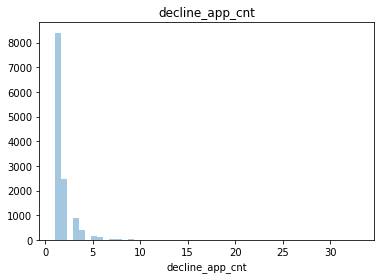

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


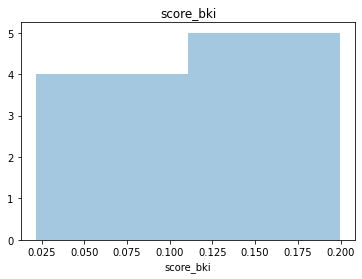

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


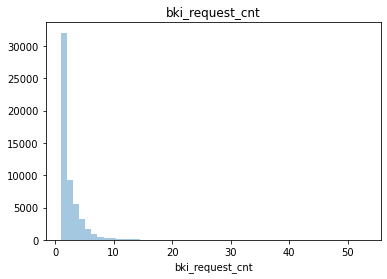

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


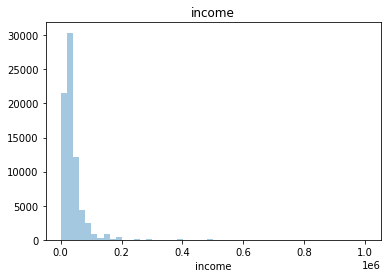

In [17]:
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Прологарифмируем переменные, распределение которых смещено

In [18]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

for i in num_cols_log:
    train[i] = np.log(train[i] + 1)

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


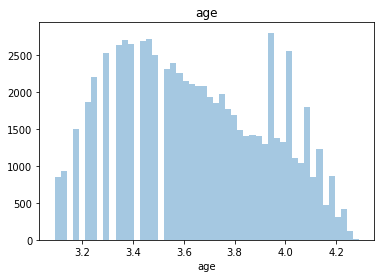

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


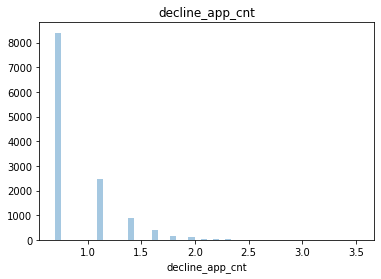

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


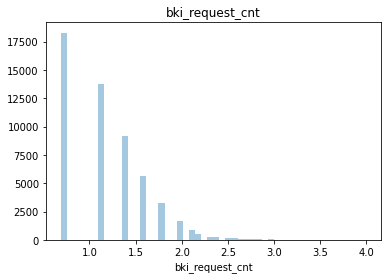

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


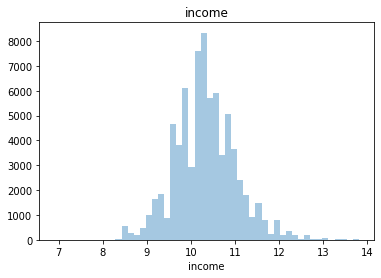

In [19]:
for i in num_cols_log:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

### Сделаем оценку корреляций для числовых столбцов

<AxesSubplot:>

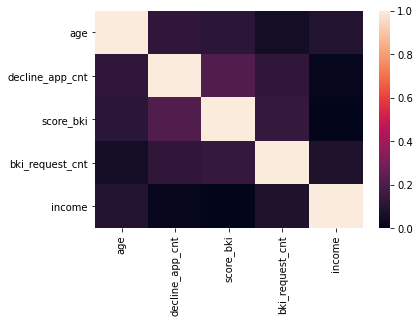

In [20]:
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1)

Как мы видим, все признаки плохо скоррелированы между собой

### Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn

Text(0.5, 0, 'F-value')

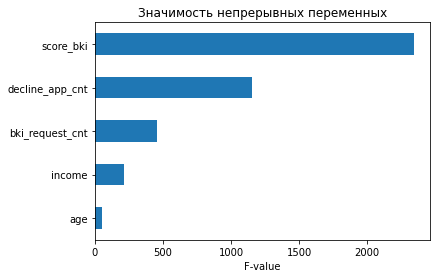

In [21]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных переменных')
plt.xlabel('F-value')

Самый значимый из числовых переменных признак score_bki, незначимый - age

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [22]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0


Как мы помним, в столбце образования пять категорий, преобразуем их с помощью get-dummies

In [23]:
train = pd.get_dummies(train, columns=['education'])
test = pd.get_dummies(test, columns=['education'])

Так же можно преобразовать столбец region_rating

In [24]:
train = pd.get_dummies(train, columns=['region_rating'])
test = pd.get_dummies(test, columns=['region_rating'])

### Для оценки значимости бинарных и категориальных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn

Text(0.5, 1.0, 'Значимость бинарных переменных')

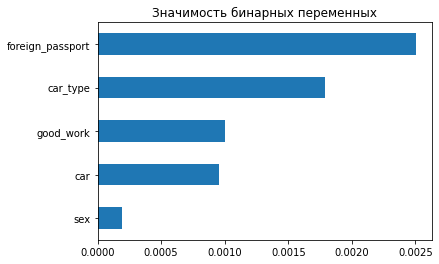

In [25]:
imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'], discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных переменных')

Самый значимый из бинарных переменных признак foreign_passport, незначимый - sex

Text(0.5, 1.0, 'Значимость категориальных переменных')

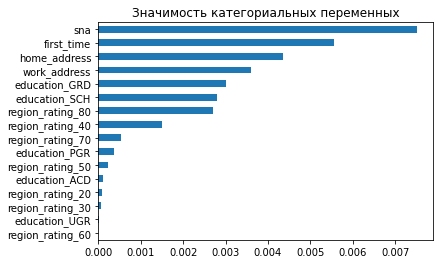

In [27]:
cat_cols = [
    'home_address', 'work_address', 'sna', 'first_time', 'education_ACD',
    'education_GRD', 'education_PGR', 'education_SCH', 'education_UGR',
    'region_rating_20', 'region_rating_30', 'region_rating_40',
    'region_rating_50', 'region_rating_60', 'region_rating_70',
    'region_rating_80']

imp_cat = Series(mutual_info_classif(train[cat_cols], train['default'], discrete_features=True),
                 index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категориальных переменных')

Самый значимый из категориальных переменных признак - sna

### Посмотрим на целевую переменную. Распределение заёмщиков неравномерное, недефолтных клиентов заметно больше

c:\users\svetamira\miniconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='default', ylabel='count'>

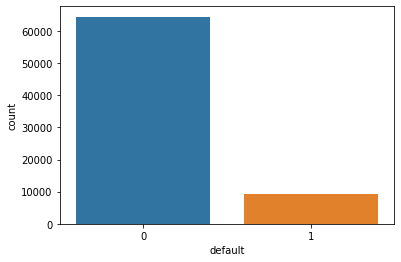

In [28]:
sns.countplot(train['default'])

Видно что недефолтных клиентов больше чем дефолтных

### Для устранения дисбаланса применим oversampling

In [29]:
train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
koeff = int(len(train_0)/len(train_1))
for i in range(koeff):
    train = train.append(train_1).reset_index(drop=True)

In [30]:
train['default'].value_counts() #проверка

1    65604
0    64427
Name: default, dtype: int64

### Проанализируем выбросы, посмотрим boxplot числовых признаков

<AxesSubplot:xlabel='default', ylabel='age'>

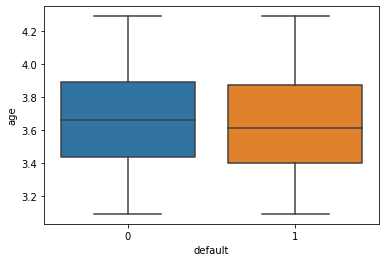

In [31]:
sns.boxplot(x=train.default, y=train.age)

Выбросов нет

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

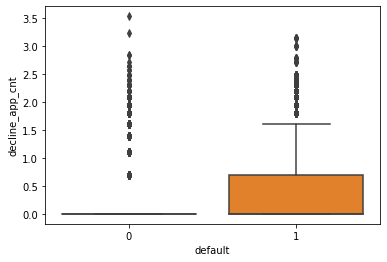

In [32]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных. Есть выбросы, но удалять их
не будем

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

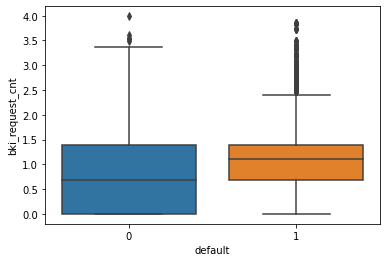

In [33]:
sns.boxplot(x=train.default, y=train.bki_request_cnt)

У дефолтных клиентов количество запросов в БКИ выше, чем у недефолтных. Есть выбросы, удалим их

<AxesSubplot:xlabel='default', ylabel='income'>

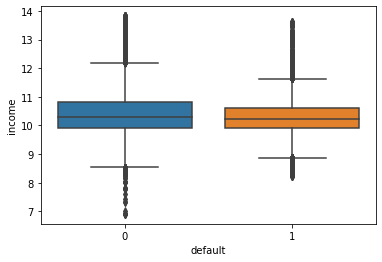

In [34]:
sns.boxplot(x=train.default, y=train.income)

Кредиты чаще выдают тем, у кого уровень дохода выше. Есть выбросы, но удалять их
не будем

Функция определяет межквартильный интервал и возвращает 1.5 межквартильных расстояния с обеих
сторон от этого интервала. С её помощью избавимся от выбросов.

In [35]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

In [36]:
#удаляем выбросы в столбце bki_request_count

num_cols1 = ['bki_request_cnt']
for colname in num_cols1:
    d = outliers_iqr(train[colname])
    train = train.loc[train[colname].between(d[0], d[1])]

### Преобразуем новые категориальные переменные с помощью метода One-Hot Encoding

In [37]:
X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
Y_cat = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)

print(X_cat.shape)
print(Y_cat.shape)

(128180, 38)
(36349, 38)


### Подготовка данных к машинному обучению

In [38]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(train[num_cols].values)
print(X_num.shape)

Y_num = StandardScaler().fit_transform(test[num_cols])
print(Y_num.shape)

(128180, 5)
(36349, 5)


Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [39]:
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

### Подбор гиперпараметров (регуляризация)

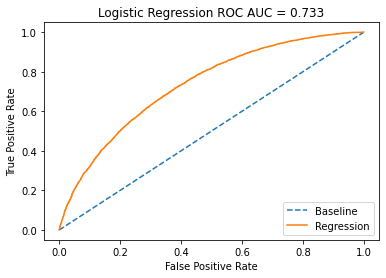

In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [42]:
# Зададим ограничения для параметра регуляризации
penalty = ['l1', 'l2']

C = np.logspace(0, 4, 10)
hyperparameters = {'C': [0.01, 0.1, 1]}
#hyperparameters = dict(C=C, penalty=penalty)
#это не сработало, не знаю почему, на slack подсмотрела подсказку заменить на то, что выше

model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 0.01


### Обучение и метрики

In [43]:
model = LogisticRegression(penalty='l2', C=0.01, max_iter=800)
#model = LogisticRegression(penalty='l2', C=7.742636826811269, max_iter=800)
#так как не получилось значение 7.74... использую что получилось у меня - 0.01
model.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=800)

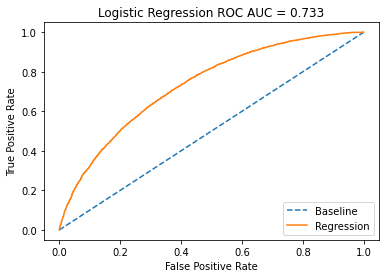

In [44]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# Визуализация ROC AUC
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [46]:
# confusion matrix
Y_predicted = model.predict(X_test)
cm = confusion_matrix(y_test, Y_predicted)
cm

array([[8570, 4381],
       [4162, 8523]], dtype=int64)

### Выводы


roc auc = 0.733